In [3]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params, w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{w_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{w_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{w_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{w_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{w_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{w_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [4]:
prefix = './retrieval_outputs/fiducial_J_B_ret_8/test_'
w_set = 'J1226'
n_params = 29

res = read_results(prefix=prefix, n_params=n_params, w_set=w_set)
posterior, bestfit, PT, Chem, _, _, _, m_spec, d_spec, LogLike, Cov, bestfit_params = res
del res

  analysing data from ./retrieval_outputs/fiducial_J_B_ret_8/test_.txt
(2463, 29)


In [5]:
from scipy.interpolate import interp1d
import petitRADTRANS.nat_cst as nc

def rot_broadening_integration(vsini, epsilon_limb=0, epsilon_lat=0, dif_rot_delta=0, dif_rot_phi=1, nr=10, ntheta=100, wave=None, flux=None):
    
    # Adopted from Carvalho & Johns-Krull (2023)

    # Set-up interpolation beforehand
    interp_func = interp1d(wave, flux, kind='linear', bounds_error=False)

    flux_rot_broad = np.zeros_like(flux)
    disk_area_tot = 0.0

    all_r     = []
    all_theta = []
    all_v     = []
    all_f     = []

    dr = 1/nr # Radial grid spacing
    # Loop over radial grid
    for i in range(nr):

        r_i = dr/2 + i*dr
        ntheta_r_i = int(ntheta*r_i)

        # Projected area
        area_ij = ((r_i + dr/2)**2 - (r_i - dr/2)**2) / ntheta_r_i
        
        # Loop over angle
        
        #for j in range(ntheta_r_i+1):
        for j in range(ntheta_r_i):
            th_j = (np.pi + j*2*np.pi) / ntheta_r_i

            # Velocity of grid-point
            vl_ij = vsini * r_i * np.sin(th_j)
            
            if dif_rot_delta != 0:
                # Apply differential rotation
                vl_ij *= (
                    1 - dif_rot_delta/2 + dif_rot_delta/2 * np.cos(dif_rot_phi*2*np.arcsin(r_i*np.cos(th_j)))
                    )
                
            # Factor to keep track of (limb)-darkening
            f_ij = 1
            if epsilon_limb != 0:
                # Apply linear limb-darkening
                f_ij *= (1 - epsilon_limb + epsilon_limb*np.sqrt(1-r_i**2))
            if epsilon_lat != 0:
                # Apply latitude-darkening
                f_ij *= (
                    1 - epsilon_lat/2 + epsilon_lat/2 * np.cos(dif_rot_phi*2*np.arcsin(r_i*np.cos(th_j)))
                    )
            
            # Apply Doppler shift
            wave_shifted_ij = wave * (1 + vl_ij/(nc.c*1e-5))
            flux_shifted_ij = np.interp(wave_shifted_ij, wave, flux, left=np.nan, right=np.nan)

            # Add to the global spectrum
            flux_rot_broad += f_ij * area_ij * flux_shifted_ij
            disk_area_tot  += f_ij * area_ij

            all_r.append(r_i)
            all_theta.append(th_j)
            all_v.append(vl_ij)
            all_f.append(f_ij)

    # Normalize to account for over/under-estimation of disk area
    flux_rot_broad /= disk_area_tot

    return wave, flux_rot_broad, np.array(all_r), np.array(all_theta), np.array(all_v), np.array(all_f)

from astropy.modeling.models import Lorentz1D
wave = np.linspace(2170.0,2230.0,10001)
fwhm = 0.05 #0.01

flux_init = np.ones_like(wave)
flux_init -= Lorentz1D(amplitude=0.5, x_0=2200, fwhm=fwhm)(wave)

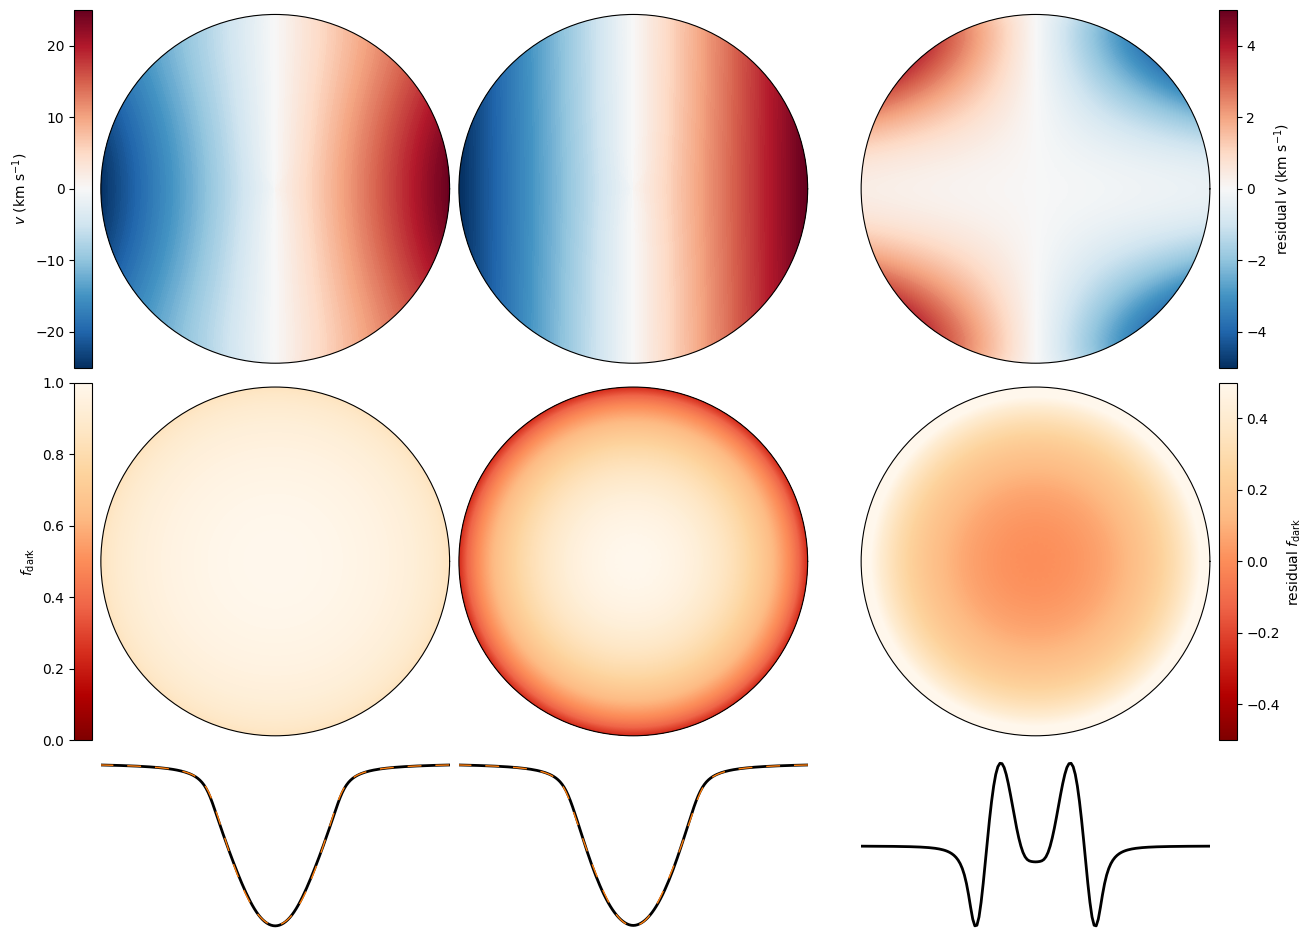

In [43]:
nr, ntheta = 10, 100
nr, ntheta = 20, 200

_, flux_local, _, _, all_v_local, all_f_local = rot_broadening_integration(
    vsini=1, epsilon_limb=0, epsilon_lat=0, dif_rot_delta=0, dif_rot_phi=1, 
    nr=nr, ntheta=ntheta, wave=wave, flux=flux_init, 
    )

_, flux_ref, _, _, all_v_ref, all_f_ref = rot_broadening_integration(
    #vsini=25, epsilon_limb=0.5, epsilon_lat=0, dif_rot_delta=0, dif_rot_phi=1, 
    vsini=25.9, epsilon_limb=1.0, epsilon_lat=0, dif_rot_delta=0, dif_rot_phi=1, 
    nr=nr, ntheta=ntheta, wave=wave, flux=flux_init, 
    )

wave, flux_mod, all_r, all_theta, all_v_mod, all_f_mod = rot_broadening_integration(
    #vsini=25, epsilon_limb=0.65, epsilon_lat=0.5, dif_rot_delta=0, dif_rot_phi=1, 
    #vsini=25, epsilon_limb=0.65, epsilon_lat=0.5, dif_rot_delta=0, dif_rot_phi=8, 
    #vsini=24.7, epsilon_limb=0.76, epsilon_lat=0.87, dif_rot_delta=0, dif_rot_phi=2.9, 
    vsini=25.5, epsilon_limb=0.2, epsilon_lat=0.0, dif_rot_delta=0.23, dif_rot_phi=1.5, 
    nr=nr, ntheta=ntheta, wave=wave, flux=flux_init, 
    )

def plot_tricontourf(ax, x, y, z, cax=None, levels=200, **kwargs):
    
    cntr = ax.tricontourf(x-np.pi/2, y, z, levels=levels, **kwargs)
    
    mask = np.ones_like(z, dtype=bool)
    ax.tricontourf(-(x[mask]-np.pi/2), y[mask], z[mask], levels=levels, **kwargs)

    if cax is not None:
        import matplotlib as mpl
        norm = mpl.colors.Normalize(vmin=kwargs.get('vmin'), vmax=kwargs.get('vmax'))
        plt.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=kwargs.get('cmap')), ax=ax, cax=cax
            )

    return cntr

fig = plt.figure(figsize=(15,12))
gs = fig.add_gridspec(
    nrows=3, ncols=6, #left=0.15, right=0.89, top=0.98, bottom=0.08, 
    width_ratios=[0.05,1,1,0.1,1,0.05], height_ratios=[1,1,0.5], 
    hspace=0.05, wspace=0.05,
    )

cax = np.array([
    [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,-1])], 
    [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,-1])]
    ])

ax = np.array([
    [fig.add_subplot(gs[0,1],projection='polar'), fig.add_subplot(gs[0,2],projection='polar'), fig.add_subplot(gs[0,4],projection='polar')], 
    [fig.add_subplot(gs[1,1],projection='polar'), fig.add_subplot(gs[1,2],projection='polar'), fig.add_subplot(gs[1,4],projection='polar')], 
    [fig.add_subplot(gs[2,1]), fig.add_subplot(gs[2,2]), fig.add_subplot(gs[2,4])], 
    ])

for i, ax_i in enumerate(ax[:2,:].flatten()):
    ax_i.grid(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.set_ylim(all_r.min(),all_r.max())

plot_tricontourf(
    ax[0,0], all_theta, all_r, all_v_mod, cmap='RdBu_r', vmin=-25, vmax=25, cax=cax[0,0]
    )
plot_tricontourf(
    ax[0,1], all_theta, all_r, all_v_ref, cmap='RdBu_r', vmin=-25, vmax=25
    )
plot_tricontourf(
    ax[0,2], all_theta, all_r, all_v_mod-all_v_ref, cmap='RdBu_r', vmin=-5, vmax=5, cax=cax[0,1]
    )

plot_tricontourf(
    ax[1,0], all_theta, all_r, all_f_mod, cmap='OrRd_r', vmin=0, vmax=1, cax=cax[1,0], 
    )
plot_tricontourf(
    ax[1,1], all_theta, all_r, all_f_ref, cmap='OrRd_r', vmin=0, vmax=1, 
    )
plot_tricontourf(
    ax[1,2], all_theta, all_r, all_f_mod-all_f_ref, cmap='OrRd_r', vmin=-0.5, vmax=+0.5, cax=cax[1,1], 
    )

ax[2,0].plot(wave, flux_mod, c='k', lw=2)
ax[2,0].plot(wave, flux_ref, c='C1', lw=1, ls=(0,(10,10)))
ax[2,1].plot(wave, flux_ref, c='k', lw=2)
ax[2,1].plot(wave, flux_mod, c='C1', lw=1, ls=(0,(10,10)))
ax[2,2].plot(wave, flux_mod-flux_ref, c='k', lw=2)

for cax_i in cax[:,0].flatten():
    cax_i.yaxis.tick_left()
    cax_i.yaxis.set_label_position('left')
cax[0,0].set(ylabel=r'$v\ \mathrm{(km\ s^{-1})}$')
cax[0,1].set(ylabel=r'residual $v\ \mathrm{(km\ s^{-1})}$')

cax[1,0].set(ylabel=r'$f_\mathrm{dark}$')
cax[1,1].set(ylabel=r'residual $f_\mathrm{dark}$')

for i, ax_i in enumerate(ax[-1,:].flatten()):
    ax_i.axis('off')
    ax_i.set_xlim(2200-0.5,2200+0.5)

plt.show()

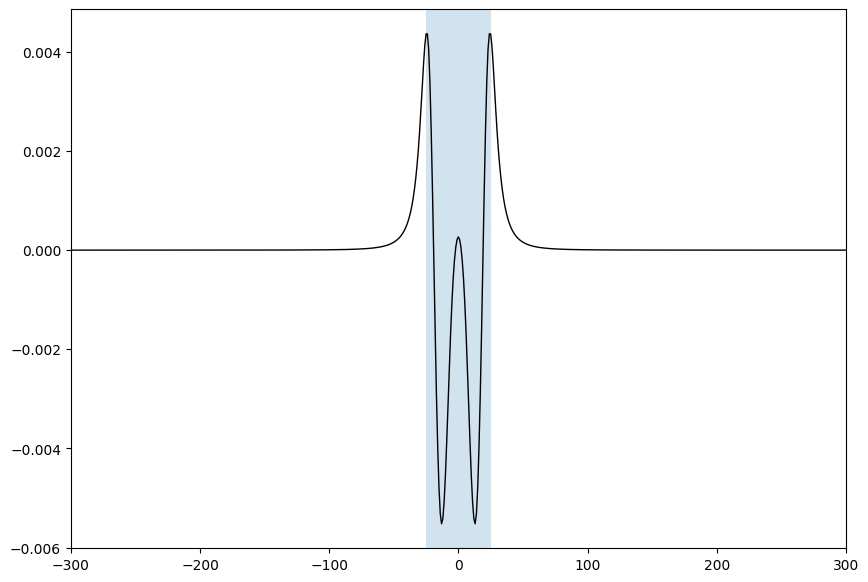

In [44]:
rv = np.arange(-300,300+1e-6,1)
CCF = np.ones_like(rv) * np.nan

for i, rv_i in enumerate(rv):

    wave_shifted = wave * (1+rv_i/3e5)
    #flux_shifted = np.interp(wave_shifted[200:-200], wave, flux)
    flux_shifted = np.interp(wave_shifted[200:-200], wave, flux_mod-flux_ref)

    #CCF[i] = np.nansum(flux_shifted * flux_ref[200:-200])
    CCF[i] = np.nansum(flux_shifted * flux_local[200:-200])

fig, ax = plt.subplots(figsize=(10,7))
ax.axvspan(xmin=-25, xmax=+25, fc='C0', ec='none', alpha=0.2)
ax.plot(rv, CCF, c='k', lw=1)
ax.set(xlim=(-300,300))
plt.show()

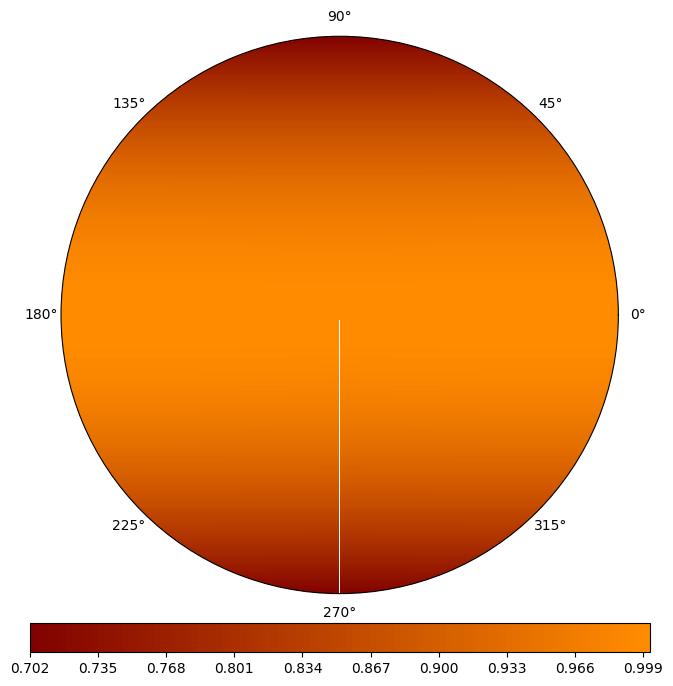

0.7 1.0


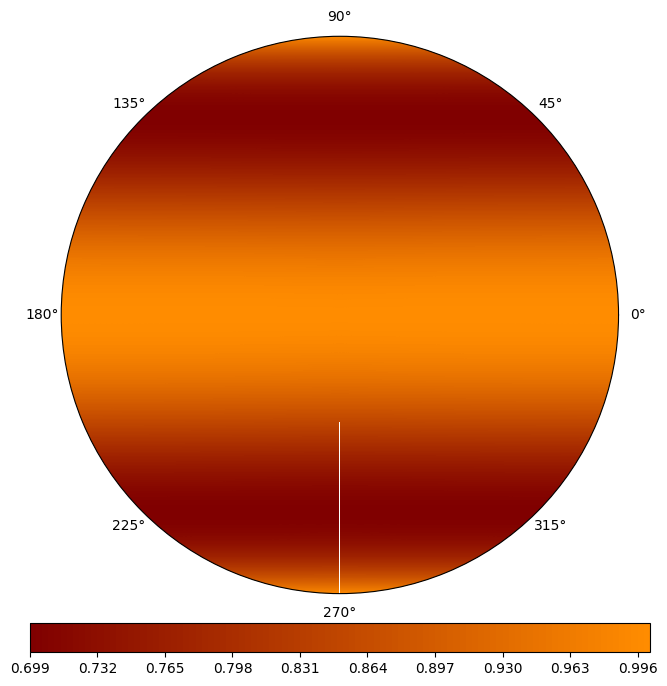

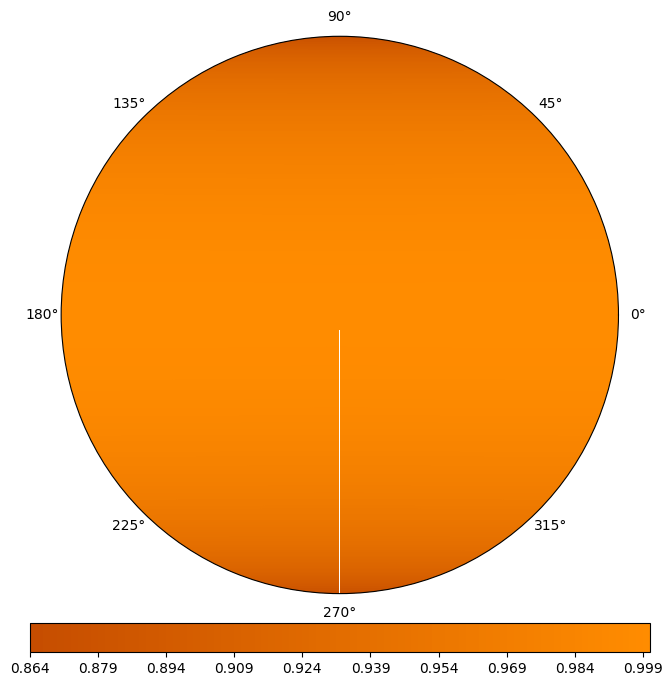

In [223]:
from matplotlib.colors import LinearSegmentedColormap

#cmap = 'gist_heat'
cmap = LinearSegmentedColormap.from_list('', colors=['maroon','darkorange'])
#kwargs = {'levels':levels, 'cmap':cmap, 'vmin':0, 'vmax':1.0}
kwargs = {'levels':levels, 'cmap':cmap, 'vmin':0.7, 'vmax':1.0}

fig, ax = plt.subplots(
    figsize=(8,8), nrows=2, subplot_kw={'projection':'polar'}, gridspec_kw={'height_ratios':[0.95,0.05], 'hspace':0.1}
    )
ax[1].remove()
ax[1] = fig.add_subplot(2,1,2)
ax[0].grid(False); ax[0].set_yticks([])
cntr = ax[0].tricontourf(
    all_theta-np.pi/2, all_r, , **kwargs
    )
cb = plt.colorbar(cntr, ax=ax[0], cax=ax[1], orientation='horizontal')
#ax[1].set(xlim=(kwargs.get('vmin'),kwargs.get('vmax')), xticks=np.arange(0.7,1+1e-6,0.1))
plt.show()

fig, ax = plt.subplots(
    figsize=(8,8), nrows=2, subplot_kw={'projection':'polar'}, gridspec_kw={'height_ratios':[0.95,0.05], 'hspace':0.1}
    )
ax[1].remove()
ax[1] = fig.add_subplot(2,1,2)
ax[0].grid(False); ax[0].set_yticks([])
cntr = ax[0].tricontourf(
    all_theta-np.pi/2, all_r, 1-0.3/2+0.3/2*np.cos(2*np.arcsin(all_r*np.cos(all_theta))), **kwargs
    )
cb = plt.colorbar(cntr, ax=ax[0], cax=ax[1], orientation='horizontal')
#ax[1].set(xlim=(kwargs.get('vmin'),kwargs.get('vmax')), xticks=np.arange(0.7,1+1e-6,0.1))
plt.show()
#print(kwargs.get('vmin'),kwargs.get('vmax'))

fig, ax = plt.subplots(
    figsize=(8,8), nrows=2, subplot_kw={'projection':'polar'}, gridspec_kw={'height_ratios':[0.95,0.05], 'hspace':0.1}
    )
ax[1].remove()
ax[1] = fig.add_subplot(2,1,2)
ax[0].grid(False); ax[0].set_yticks([])
cntr = ax[0].tricontourf(
    all_theta-np.pi/2, all_r, 1-0.3/2+0.3/2*np.cos(2*2*np.arcsin(all_r*np.cos(all_theta))), **kwargs
    )
cb = plt.colorbar(cntr, ax=ax[0], cax=ax[1], orientation='horizontal')
#cb.ax.set_xlim(kwargs.get('vmin'),kwargs.get('vmax'))
plt.show()

fig, ax = plt.subplots(
    figsize=(8,8), nrows=2, subplot_kw={'projection':'polar'}, gridspec_kw={'height_ratios':[0.95,0.05], 'hspace':0.1}
    )
ax[1].remove()
ax[1] = fig.add_subplot(2,1,2)
ax[0].grid(False); ax[0].set_yticks([])
cntr = ax[0].tricontourf(
    all_theta-np.pi/2, all_r, 1-0.3/2+0.3/2*np.cos(0.5*2*np.arcsin(all_r*np.cos(all_theta))), **kwargs
    )
cb = plt.colorbar(cntr, ax=ax[0], cax=ax[1], orientation='horizontal')
#cb.ax.set_xlim(kwargs.get('vmin'),kwargs.get('vmax'))
plt.show()

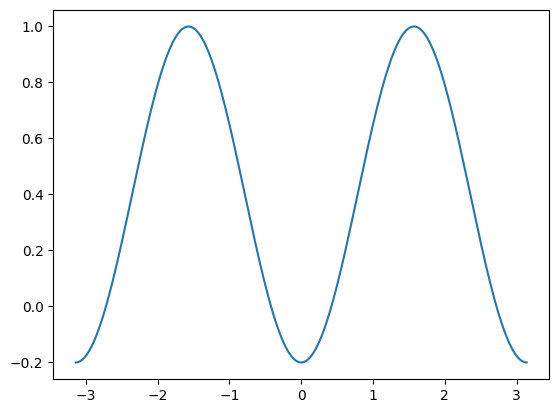

In [151]:
x = np.linspace(-np.pi, np.pi, 200)

'''
delta = 0.1
plt.plot(x, 1-delta/2-delta/2*np.cos(x))

delta = 0.8
plt.plot(x, 1-delta/2-delta/2*np.cos(x))

delta = 1.2
plt.plot(x, 1-delta/2-delta/2*np.cos(x))
'''

delta = 0.
#plt.plot(x, 1-delta/2-delta/2*np.cos(x)**2)

delta = 1.2
#plt.plot(x, 1-delta/2-delta/2*np.cos(x)**2)

#plt.plot(x, 1.0-(1.0-0.2)*np.sin(x)**2)
plt.plot(x, 1-delta/2-delta/2*np.cos(2*x))

plt.show()